In [21]:
!pip install path

In [22]:
from text import *

In [7]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import pandas as pd

# Download Dataset

In [1]:
!wget http://www.statmt.org/europarl/v7/europarl.tgz

--2020-10-28 22:12:36--  http://www.statmt.org/europarl/v7/europarl.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1570461714 (1.5G) [application/x-gzip]
Saving to: ‘europarl.tgz’

europarl.tgz        100%[===================>]   1.46G   214KB/s    in 41m 48s 

2020-10-28 22:54:25 (611 KB/s) - ‘europarl.tgz’ saved [1570461714/1570461714]



In [7]:
%%capture
!tar -xvf  '/content/europarl.tgz' -C '/content/tmp'

# Create and Process Text Data

In [27]:
max_words = 2000000
max_lenght = 20 # between 2 and 20
name = "data"
n_jobs = 3
p = 0.7

# answer = input("do you need to create new dataset files (y/n)?: ")
# answer = answer.lower()
cfiles = True

In [28]:
%%time
df = main(labels, max_words, max_lenght, name, n_jobs, cfiles)
l = len(df)
idxs = np.random.permutation(l)
train_ds = df.loc[idxs[:int(p*l)]]
valid_ds = df.loc[idxs[int(p*l)+1:]]
train_ds.reset_index(drop=True, inplace=True)
valid_ds.reset_index(drop=True, inplace=True)
save_dataframe("train_ds", train_ds)
save_dataframe("valid_ds", valid_ds)

CPU times: user 15.3 s, sys: 5.35 s, total: 20.7 s
Wall time: 29min 36s


In [30]:
train_ds.shape, valid_ds.shape

((2718013, 2), (1164863, 2))

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# !cp -R "/content/europarl" "/content/drive/My Drive/"

# Train AWD_LSTM Model

In [3]:
labels=['bg','cs','da','de','el','en','es','et','fi','fr',
        'hu','it','lt','lv','nl','pl','pt','ro','sk','sl','sv']

In [5]:
train_df = pd.read_pickle("/content/drive/My Drive/europarl/train_ds.pkl")
valid_df = pd.read_pickle("/content/drive/My Drive/europarl/valid_ds.pkl")

train_df.label.replace([i for i in range(len(labels))], labels, inplace=True)
valid_df.label.replace([i for i in range(len(labels))], labels, inplace=True)
train_df.head()
train_df.shape, valid_df.shape

((2718013, 2), (1164863, 2))

In [8]:
bs = 512

In [9]:
tdb = TextClasDataBunch.from_df(".", train_df, valid_df, classes=labels, text_cols="text", 
                                label_cols="label", max_vocab=200000, bs=bs)

In [10]:
f1 = FBeta()
f1.avg = "micro"
metrics = [f1]

In [11]:
learn = text_classifier_learner(tdb, AWD_LSTM, drop_mult=0.5, metrics=metrics)
# learn.summary()

In [12]:
learn.freeze()

epoch,train_loss,valid_loss,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


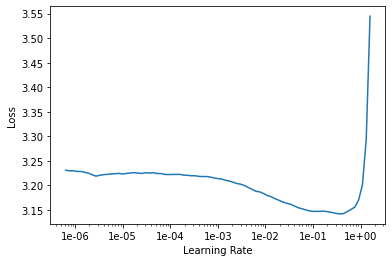

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
cbs = [SaveModelCallback(learn, every='epoch', monitor='accuracy', name='model')]

In [15]:
learn.fit_one_cycle(4, 1e-01, callbacks=cbs)

epoch,train_loss,valid_loss,f_beta,time
0,2.959264,2.924483,0.038864,12:04


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


KeyboardInterrupt: ignored

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, 1e-01, callbacks=cbs)

In [ ]:
learn.recorder.plot_losses()

# Using Custom Tokenization

In [5]:
from tokenizer import SpecialTokenizer, _default_tokenizer
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import pandas as pd

In [2]:
train_df = pd.read_pickle("/content/drive/My Drive/europarl/train_ds.pkl")
valid_df = pd.read_pickle("/content/drive/My Drive/europarl/valid_ds.pkl")
train_df.shape, valid_df.shape

((2718013, 2), (1164863, 2))

In [3]:
t = SpecialTokenizer.from_pickle("/content/tokenizer.pkl")

In [6]:
def get_tokens(t):
    return list(t.vocab.get_vocab().keys())
v = Vocab(get_tokens(t))

In [7]:
def flatten(rank_2):
    return list(itertools.chain.from_iterable(rank_2))

In [ ]:
# trn_tok = [flatten(t.tokenize_single(x)) for x in train_df['text']]
val_tok = [flatten(t.tokenize_single(x)) for x in valid_df['text']]

In [11]:
# ! cp tokenizer.pkl "/content/drive/My Drive/europarl/tokenizer.pkl"
# ! cp text.py "/content/drive/My Drive/europarl/text.py"
# ! cp tokenizer.py "/content/drive/My Drive/europarl/tokenizer.py"
# ! cp vocab.py "/content/drive/My Drive/europarl/vocab.py"